In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.viewer import pv
from pygimli.physics.gravimetry import MagneticsModelling

In [2]:
A = np.genfromtxt("fault-synth.mag", names=True)
points = np.column_stack([A["x"], A["y"], -A["z"]])
dx = 50.
x = np.arange(-600, 601, dx)
z = z=np.arange(-800, 1, dx)
grid = mt.createGrid(x=x, y=x, z=z)
print(grid)

Mesh: Nodes: 10625 Cells: 9216 Boundaries: 28992


In [3]:
import pyIGRF
igrf = pyIGRF.igrf_value(lat=50.59465, lon=12.64139)
fopT = MagneticsModelling(grid.NED(), points, cmp=["TFA"], igrf=igrf)

   0%|          |0/861 [00:00 < ?]

In [4]:
bz = np.array([abs(b.center().z()) for b in grid.boundaries() if not b.outside()])
cz = np.abs(pg.z(grid.cellCenter()))
z0 = 25
a0 = 100
wb = 100 / (bz+z0)**1.5
wc = 100 / (cz+z0)**1.5
print(min(wb), max(wb), min(wc), max(wc))

0.004419417382415922 0.282842712474619 0.004419417382415922 0.282842712474619


In [5]:
noise_level = 3
data = A["TFA"]
data += np.random.randn(len(data)) * noise_level

In [6]:
invT = pg.Inversion(fop=fopT, verbose=True)
cType = 1
invT.setRegularization(cType=cType, limits=[0, 0.1])  # to limit values
if cType == 2:
    invT.setConstraintWeights(wc)
else:
    invT.setConstraintWeights(wb)
    
grid["invT"] = invT.run(data, absoluteError=noise_level, lam=100, startModel=1e-3, verbose=True)

18/11/23 - 20:20:44 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.gravimetry.MagneticsModelling.MagneticsModelling object at 0x000001D5309019F0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001D530963AC0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001D53093F9A0>
min/max (data): -20.25/75.92
min/max (error): 3.95%/6.1e+05%
min/max (start model): 1.0e-03/1.0e-03
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =   23.40
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   17.84 (dPhi = 23.74%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    9.70 (dPhi = 45.51%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.88 (dPhi = 69.68%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi

In [7]:
fault = mt.readPLC("fault.poly")
print(fault)

Mesh: Nodes: 8 Cells: 0 Boundaries: 6


In [8]:
pl, _ = pg.show(grid, label="invT", style="surface", hold=True, backend="trame",
                filter={"threshold": dict(value=0.025, scalars="invT")})
pv.drawModel(pl, fault, style="wireframe")
pv.drawMesh(pl, grid, label="invT", style="surface", cMap="Spectral_r", cMin=0, cMax=0.05,
            filter={"slice": dict(normal=[-1, 0, 0], origin=[0, 0, 0])})
pl.camera_position = "yz"
pl.camera.elevation = 10
pl.camera.zoom(1.2)
_ = pl.show()

Widget(value="<iframe src='http://localhost:60190/index.html?ui=P_0x1d551f47af0_0&reconnect=auto' style='width…

75.92291772375594


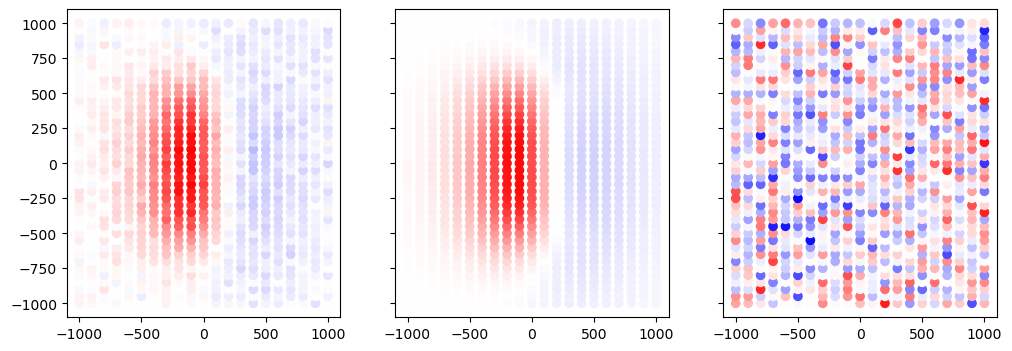

In [9]:
fig, ax = pg.plt.subplots(ncols=3, figsize=(12, 4), sharex=True, sharey=True)
vals = data
mm = np.max(np.abs(vals))
print(mm)
ax[0].scatter(A["x"], A["y"], c=vals, cmap="bwr", vmin=-mm, vmax=mm);
ax[1].scatter(A["x"], A["y"], c=invT.response, cmap="bwr", vmin=-mm, vmax=mm);
misfit = (data - invT.response) / noise_level
ax[2].scatter(A["x"], A["y"], c=misfit, cmap="bwr", vmin=-3, vmax=3);

In [10]:
cmp = ["Bx", "By", "Bz"]
fopB = MagneticsModelling(grid.NED(), points, cmp=cmp, igrf=igrf)

   0%|          |0/861 [00:00 < ?]

In [11]:
data = np.concatenate([A[c] for c in cmp])
data += np.random.randn(len(data)) * noise_level

In [12]:
invB = pg.Inversion(fop=fopB, verbose=True)
invB.setRegularization(limits=[0, 0.1])  # to limit values
invB.setConstraintWeights(wb)
grid["invB"] = invB.run(data, absoluteError=noise_level, lam=100, startModel=1e-3, verbose=True)

18/11/23 - 20:22:11 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.gravimetry.MagneticsModelling.MagneticsModelling object at 0x000001D5658986D0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001D5681BD7C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001D5681BD700>
min/max (data): -49.55/81.49
min/max (error): 3.68%/5.3e+04%
min/max (start model): 1.0e-03/1.0e-03
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =   16.66
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   12.66 (dPhi = 24.02%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.57 (dPhi = 47.99%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.13 (dPhi = 67.21%) lam: 100.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi

In [18]:
pl, _ = pg.show(grid, label="invB", style="surface", hold=True, backend="trame",
                filter={"threshold": dict(value=0.02, scalars="invB")}, cMin=0, cMax=0.04)
pv.drawModel(pl, fault, style="wireframe")
pv.drawMesh(pl, grid, label="invB", style="surface", cMap="Spectral_r", cMin=0, cMax=0.04,
            filter={"slice": dict(normal=[-1, 0, 0], origin=[0, 0, 0])})
pl.camera_position = "yz"
pl.camera.elevation = 20
pl.camera.azimuth = 30
pl.camera.zoom(1.2)
_ = pl.show()

Widget(value="<iframe src='http://localhost:60190/index.html?ui=P_0x1d59be84af0_5&reconnect=auto' style='width…

(3, 861) (3, 861)


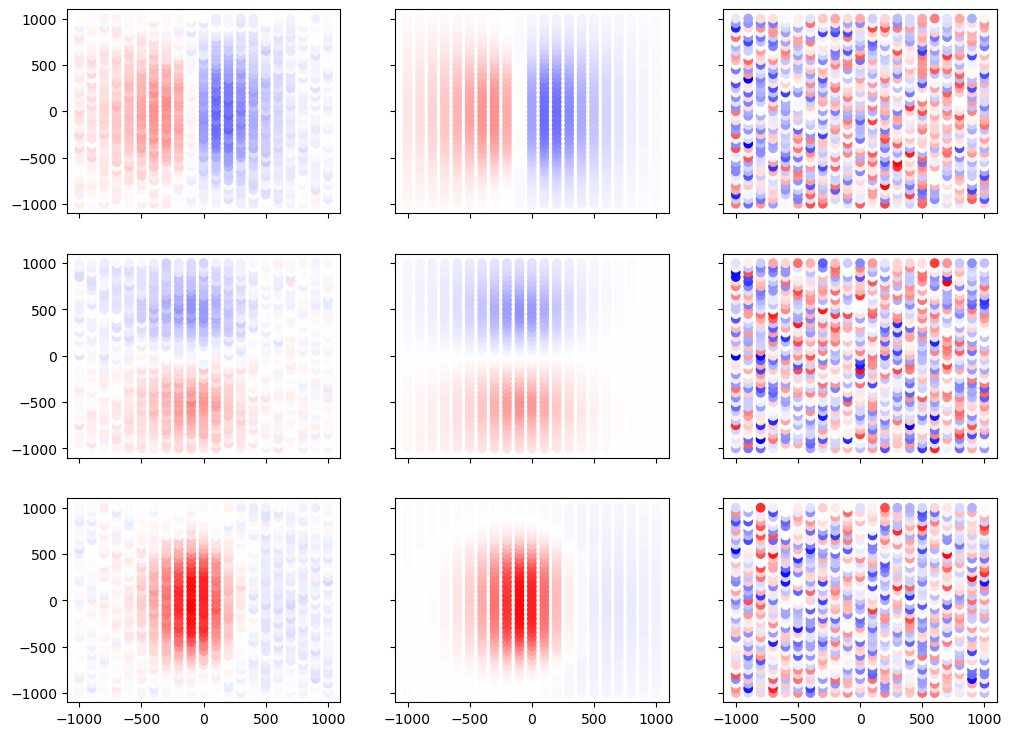

In [21]:
nc = len(cmp)
fig, ax = pg.plt.subplots(ncols=3, nrows=nc, figsize=(12, 3*nc), sharex=True, sharey=True, squeeze=False)
vals = np.reshape(data, [nc, -1])
mm = np.max(np.abs(vals))
resp = np.reshape(invB.response, [nc, -1])
for i in range(nc):
    ax[i, 0].scatter(A["x"], A["y"], c=vals[i], cmap="bwr", vmin=-mm, vmax=mm)
    ax[i, 1].scatter(A["x"], A["y"], c=resp[i], cmap="bwr", vmin=-mm, vmax=mm)
    misfit = (vals[i] - resp[i]) / noise_level
    ax[i, 2].scatter(A["x"], A["y"], c=misfit, cmap="bwr", vmin=-3, vmax=3)

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1d590815310>)

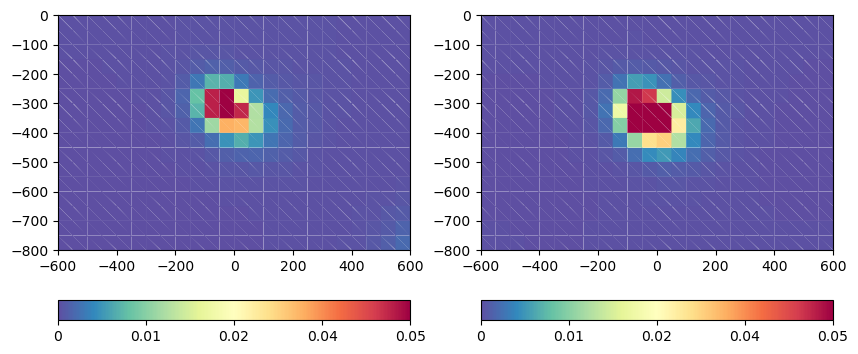

In [22]:
sli = mt.extract2dSlice(grid, normal="x")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
pg.show(sli, "invT", cMin=0, cMax=0.05, cMap="Spectral_r", ax=ax[0])
pg.show(sli, "invB", cMin=0, cMax=0.05, cMap="Spectral_r", ax=ax[1])